In [ ]:
# Copyright 2025 AIT Austrian Institute of Technology GmbH
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Author: Miguel Castells

In [ ]:
import open_clip
from huggingface_hub import hf_hub_download
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import clip
from tqdm.auto import tqdm
import os
import json
from transformers import AutoProcessor, AutoModel

In [ ]:
device = 'cuda:0'

"# examples\nimg = Image.open('/workspace/data/Satlas/val_set/naip/m_2408115_sw_17_060_20191128/35956_56214/rgb.png')\nimg2 = Image.open('/workspace/data/Satlas/val_set/naip/m_2408122_ne_17_060_20191128/35944_56235/rgb.png') \nimg3 = Image.open('/workspace/data/Satlas/val_set/naip/m_2408129_ne_17_060_20191128/35904_56295/rgb.png') \nimg4 = Image.open('/workspace/data/Satlas/val_set/naip/m_4911662_se_11_060_20190820/23190_44989/rgb.png') \nlist_imgs = [img, img2, img3, img4]"

# Remote-CLIP
## Download weights

In [ ]:
'''for model_name in ['ViT-L-14']:
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')'''

ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


## Compute Remote-CLIP

In [ ]:
rem_model_name = 'ViT-L-14' 
rem_model, _, rem_preprocess = open_clip.create_model_and_transforms(rem_model_name)

ckpt = torch.load(f"PATH_TO_CHECKPOINTS/checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt", map_location="cpu")
message = rem_model.load_state_dict(ckpt)
print(message)

rem_model = rem_model.to(device).eval()

<All keys matched successfully>


In [15]:
def compute_rem_clip_feats(list_img):
    '''
    Input : list of PIL.Image 
    Return features of shape [B, 768], B = len(list_img)
    '''
    processed_images = torch.stack([rem_preprocess(img) for img in list_img])

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = rem_model.encode_image(processed_images.to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)

    return image_features

#compute_rem_clip_feats([img, img2, img3, img4])

# OPENAI-CLIP
## Download model (CLIPA-v2)

In [3]:
open_model_name = 'clipa-ViT-bigG-14'    

def open_load_model(open_model_name):
    if open_model_name == 'clip-ViT-B/16':
        model, _ = clip.load("ViT-B/16")
        img_size = (224,224)
    elif open_model_name == 'clipa-ViT-bigG-14':
        model, _, _ = open_clip.create_model_and_transforms('ViT-bigG-14-CLIPA-336', pretrained='datacomp1b')
        img_size = (336,336)
    elif open_model_name == 'siglip-ViT-SO400M-14':
        model, _, _ = open_clip.create_model_and_transforms('ViT-SO400M-14-SigLIP-384', pretrained='webli')
        model = model
        img_size = (384,384)
    else:
        print(clip_model, " is not supported for CLIPScore.")
    return model, img_size

#open_model, open_img_size = open_load_model(open_model_name)

In [4]:
# FOR LIST OF IMAGES
def open_preprocess(img, img_size):
    img = np.array(img)
    tensor1 = torch.as_tensor(img).permute(2, 0, 1)
    tensor1 = tensor1.unsqueeze(0).float()/255
    tensor1 = F.interpolate(tensor1, img_size)
    return tensor1.squeeze(0)

## Compute features

In [5]:
def compute_open_clip_feats(list_imgs, open_model, img_size, batch_size=5):
    '''
    Input : list of PIL.Image and the model
    Return features of shape [B, 1280], B = len(list_img)
    '''
    preprocessed_imgs = [open_preprocess(img, img_size=img_size) for img in list_imgs]

    feats = []
    open_model.eval().to(device)

    with torch.no_grad():
        for i in range(0, len(preprocessed_imgs), batch_size):
            batch = torch.stack(preprocessed_imgs[i:i+batch_size]).to(device)  # shape [B, C, H, W]
            batch_feats = open_model.encode_image(batch)
            feats.append(batch_feats.cpu())  # move to CPU to save GPU memory

    return torch.cat(feats, dim=0)

#feats = compute_open_clip_feats(list_imgs)
#feats.shape

# RS-CLIP
## Download the model

In [3]:
rs_model = AutoModel.from_pretrained("lcybuaa/Git-RSCLIP")
rs_processor = AutoProcessor.from_pretrained("lcybuaa/Git-RSCLIP")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Compute features 

In [27]:
def compute_rs_clip_feats(list_img):
    '''
    Input : list of PIL.Image 
    Return features of shape [B, 1024], B = len(list_img)
    '''
    processed_images = rs_processor(images=list_img, return_tensors="pt")

    with torch.no_grad():
        image_features = rs_model.get_image_features(**processed_images.to(device))

    return image_features


# GeoRSCLIP
## Download model

In [41]:
ckpt_path = "/workspace/framework_choose_lr/dev/clip_study/checkpoints/Geo_RSCLIP_RS5M_ViT-B-32.pt"
geo_model, _, _ = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
checkpoint = torch.load(ckpt_path, map_location="cpu")
msg = geo_model.load_state_dict(checkpoint, strict=False)
geo_model = geo_model.to(device)

In [50]:
from torchvision import transforms

def _convert_to_rgb(image):
    return image.convert('RGB')

def geo_processor():
    image_resolution = 224
    normalize = transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
        )
    preprocess_val = transforms.Compose([
            transforms.Resize(
                size=image_resolution,
                interpolation=transforms.InterpolationMode.BICUBIC,
            ),
            transforms.CenterCrop(image_resolution),
            _convert_to_rgb,
            transforms.ToTensor(),
            normalize,
        ])
    return preprocess_val

## Compute features

In [52]:
def compute_geo_clip_feats(list_img):
    '''
    Input : list of PIL.Image 
    Return features of shape [B, 512], B = len(list_img)
    '''
    processed_images = torch.stack([geo_processor()(img) for img in list_img])

    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = geo_model.encode_image(processed_images.to(device))

    return image_features

# examples
'''img = Image.open('/workspace/data/Satlas/val_set/naip/m_2408115_sw_17_060_20191128/35956_56214/rgb.png')
img2 = Image.open('/workspace/data/Satlas/val_set/naip/m_2408122_ne_17_060_20191128/35944_56235/rgb.png') 
img3 = Image.open('/workspace/data/Satlas/val_set/naip/m_2408129_ne_17_060_20191128/35904_56295/rgb.png') 
img4 = Image.open('/workspace/data/Satlas/val_set/naip/m_4911662_se_11_060_20190820/23190_44989/rgb.png') 
list_imgs = [img, img2, img3, img4]
compute_geo_clip_feats(list_imgs).shape'''

torch.Size([4, 512])

# Compute_scores

In [8]:
def compute_clip_scores_inside(feats):
    """
    Compute cosine similarities between all unique pairs in the batch (excluding duplicates).
    Args:
        feats: Tensor of shape [B, D]
    Returns:
        scores: List of cosine similarity scores, length = B*(B-1)/2
    """
    B = feats.shape[0]
    scores = []

    for i in range(B):
        ref = feats[i].unsqueeze(0) 
        others = feats[i+1:]         
        if others.shape[0] == 0:
            continue
        sim = F.cosine_similarity(ref.expand_as(others), others, dim=1)
        scores.extend(sim.cpu().tolist())

    return scores

def compute_cross_clip_scores(feats1, feats2):
    """
    Calcule les cosine similarities entre tous les couples (i,j) avec i dans feats1 et j dans feats2
    en utilisant torch.cosine_similarity.

    Args:
        feats1: Tensor [B1, D]
        feats2: Tensor [B2, D]

    Returns:
        scores: Liste de floats de taille B1*B2 avec toutes les similarités.
    """
    if torch.equal(feats1, feats2):
        return compute_clip_scores_inside(feats1)

    sim_matrix = F.cosine_similarity(feats1.unsqueeze(1), feats2.unsqueeze(0), dim=2)

    return sim_matrix.flatten().cpu().tolist()


#compute_cross_clip_scores(feats_imgs, feats_imgs[:2])

# Get Images as list of PIL.Image

In [7]:
import os

def load_images_from_subfolder(subfolder_path):
    """
    Charge toutes les images d'un dossier en liste de PIL.Image.
    Supporte les extensions courantes : jpg, jpeg, png, bmp, tiff, etc.
    
    Args:
        subfolder_path (str): chemin du sous-dossier contenant les images.
        
    Returns:
        List[PIL.Image.Image]: liste des images chargées.
    """
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    images = []
    
    # Lister les fichiers dans le dossier
    for filename in os.listdir(subfolder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(subfolder_path, filename)
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Erreur chargement image {img_path} : {e}")
    
    return images
'''
subfolder_path = "/workspace/data/AID_sample_100png/celeba_sample_100.jpg"
images = load_images_from_subfolder(subfolder_path)
print(f"Nombre d'images chargées : {len(images)}")
type(images[0])'''

'\nsubfolder_path = "/workspace/data/AID_sample_100png/celeba_sample_100.jpg"\nimages = load_images_from_subfolder(subfolder_path)\nprint(f"Nombre d\'images chargées : {len(images)}")\ntype(images[0])'

# Compute each results and save it as JSON

## Remote-CLIP

In [31]:
import json
from tqdm.auto import tqdm

dir_path = '/workspace/data/AID_100samples'

rem_model, _, rem_preprocess = open_clip.create_model_and_transforms(rem_model_name)

ckpt = torch.load(f"/workspace/framework_choose_lr/dev/clip_study/checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt", map_location="cpu")
message = rem_model.load_state_dict(ckpt)
print(message)

rem_model = rem_model.to(device).eval()

# each class is compared to Industrial
classes = ['School', 'Industrial', 'Desert', 'CelebA']
#classes = [c for c in os.listdir(dir_path)]
rem_res = {}
img_list_per_fold = {}
class_feats = {}

for c in tqdm(classes):
    subfolder_path = os.path.join(dir_path, c)
    img_list_per_fold[c] = load_images_from_subfolder(subfolder_path)
    class_feats[c] = compute_rem_clip_feats(img_list_per_fold[c])

for c, v in tqdm(class_feats.items()):
    rem_res[c] = compute_cross_clip_scores(class_feats['School'], v)

with open('/workspace/framework_choose_lr/dev/clip_study/results_scores/remote_scores.json', 'w') as file:
    json.dump(rem_res, file)

rem_model.cpu()

<All keys matched successfully>


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwi

## OPEN-CLIP (CLIPA-v2)

In [32]:
dir_path = '/workspace/data/AID_100samples'

# each class is compared to Industrial
classes = ['School', 'Industrial', 'Desert', 'CelebA']
#classes = [c for c in os.listdir(dir_path)]
open_res = {}
img_list_per_fold = {}
class_feats = {}

open_model_name = 'clipa-ViT-bigG-14' 
open_model, open_img_size = open_load_model(open_model_name)

for c in tqdm(classes):
    subfolder_path = os.path.join(dir_path, c)
    img_list_per_fold[c] = load_images_from_subfolder(subfolder_path)
    class_feats[c] = compute_open_clip_feats(img_list_per_fold[c], open_model=open_model, img_size=open_img_size)

for c, v in tqdm(class_feats.items()):
    open_res[c] = compute_cross_clip_scores(class_feats['School'], v)

with open('/workspace/framework_choose_lr/dev/clip_study/results_scores/open_scores.json', 'w') as file:
    json.dump(open_res, file)

open_model.cpu()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): Identity()
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-47): 48 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transfo

## RS-CLIP

In [33]:
dir_path = '/workspace/data/AID_100samples'

# each class is compared to Industrial
classes = ['School', 'Industrial', 'Desert', 'CelebA']
#classes = [c for c in os.listdir(dir_path)]
rs_res = {}
img_list_per_fold = {}
class_feats = {}

rs_model = AutoModel.from_pretrained("lcybuaa/Git-RSCLIP").to(device)
rs_processor = AutoProcessor.from_pretrained("lcybuaa/Git-RSCLIP")

for c in tqdm(classes):
    subfolder_path = os.path.join(dir_path, c)
    img_list_per_fold[c] = load_images_from_subfolder(subfolder_path)
    class_feats[c] = compute_rs_clip_feats(img_list_per_fold[c])

for c, v in tqdm(class_feats.items()):
    rs_res[c] = compute_cross_clip_scores(class_feats['School'], v)

with open('/workspace/framework_choose_lr/dev/clip_study/results_scores/rs_scores.json', 'w') as file:
    json.dump(rs_res, file)

rs_model.cpu()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(32000, 1024)
      (position_embedding): Embedding(64, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_feature

## Geo RSCLIP

In [ ]:
dir_path = '/workspace/data/AID_100samples'

ckpt_path = "/workspace/framework_choose_lr/dev/clip_study/checkpoints/Geo_RSCLIP_RS5M_ViT-B-32.pt"
geo_model, _, _ = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
checkpoint = torch.load(ckpt_path, map_location="cpu")
msg = geo_model.load_state_dict(checkpoint, strict=False)


'''ckpt_path = "/workspace/framework_choose_lr/dev/clip_study/checkpoints/RS5M_ViT-H-14.pt"
model, _, _ = open_clip.create_model_and_transforms("ViT-H/14", pretrained="laion2b_s32b_b79k")
checkpoint = torch.load(ckpt_path, map_location="cpu")
msg = model.load_state_dict(checkpoint, strict=False)'''

geo_model = geo_model.to(device)

# each class is compared to Industrial
classes = ['School', 'Industrial', 'Desert', 'CelebA']
#classes = [c for c in os.listdir(dir_path)]
geo_res = {}
img_list_per_fold = {}
class_feats = {}

for c in tqdm(classes):
    subfolder_path = os.path.join(dir_path, c)
    img_list_per_fold[c] = load_images_from_subfolder(subfolder_path)
    class_feats[c] = compute_geo_clip_feats(img_list_per_fold[c])

for c, v in tqdm(class_feats.items()):
    rem_res[c] = compute_cross_clip_scores(class_feats['School'], v)

with open('/workspace/framework_choose_lr/dev/clip_study/results_scores/geo_scores.json', 'w') as file:
    json.dump(rem_res, file)

geo_model.cpu()

open_clip_model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

# Plot results

In [20]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
import glob
import pandas as pd
import os
import clip
import torch
import open_clip
import torch.nn.functional as F
from transformers import AutoProcessor, AutoModel
import opensr_test as osr
from torch.utils import data as data
import torchvision.io as io
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure
from tqdm.auto import tqdm
import json
import lpips
import math

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histograms_with_means(data_dict):
    """
    data_dict: dict[str, list[float]]
    Affiche un histogramme par clé avec la moyenne indiquée en label et une ligne verticale pointillée.
    """

    plt.figure(figsize=(12, 6))
    colors = plt.cm.get_cmap('tab10', len(data_dict))  # palette de couleurs

    for i, (key, values) in enumerate(data_dict.items()):
        values = np.array(values)
        mean_val = values.mean()
        
        # Tracer histogramme avec label incluant la moyenne
        plt.hist(values, bins=30, alpha=0.6, color=colors(i), density=True, label=f"Industrial-{key} (mean={mean_val:.3f})")
        
        # Tracer ligne verticale pointillée à la moyenne
        plt.axvline(mean_val, color=colors(i), linestyle='dotted', linewidth=2)
    
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histograms with means')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation avec ton dict 'rem_dict'
#plot_histograms_with_means(d)


/tmp/ipykernel_2373834/3547561348.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(data_dict))


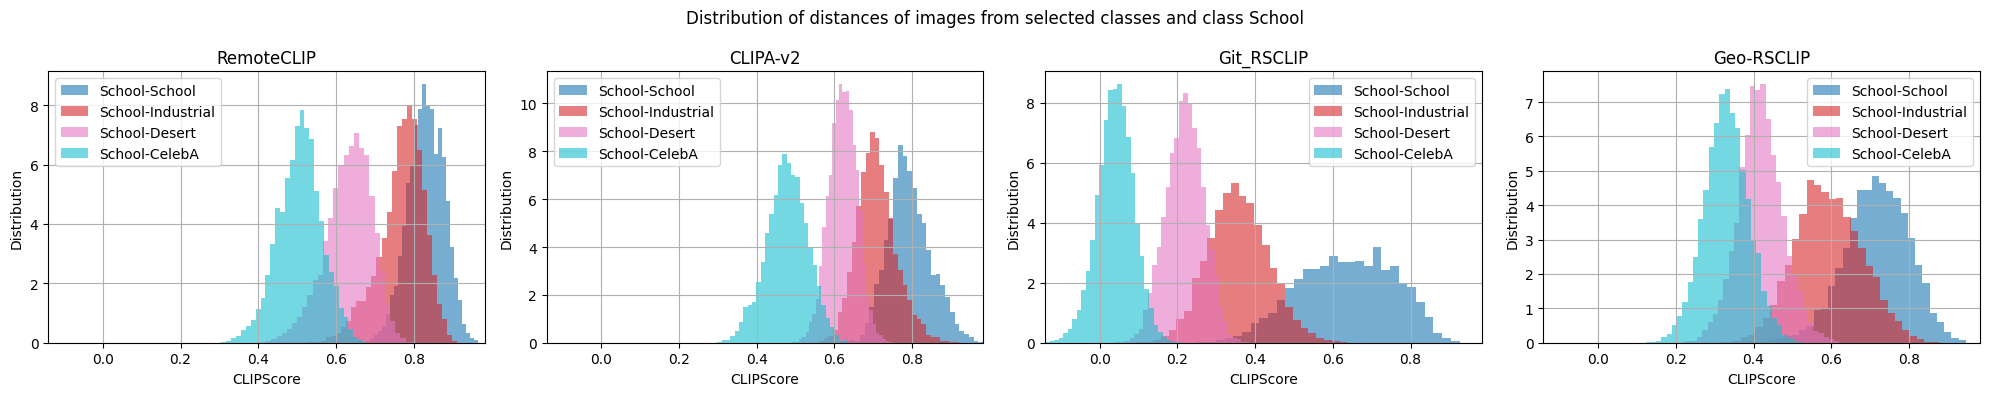

In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_dicts_histograms(dict_paths, titles):
    n = len(dict_paths)
    ncols = 4
    nrows = math.ceil(n / ncols)

    # First pass: collect all values to find global min and max
    all_values = []
    for p in dict_paths:
        data_dict = load_json(p)
        for values in data_dict.values():
            all_values.extend(values)
    
    global_min = np.min(all_values)
    global_max = np.max(all_values)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    
    for i, p in enumerate(dict_paths):
        row = i // ncols
        col = i % ncols
        ax = axes[row, col]
        
        data_dict = load_json(p)
        title = titles[i]

        colors = plt.cm.get_cmap('tab10', len(data_dict))
        
        for j, (key, values) in enumerate(data_dict.items()):
            values = np.array(values)
            mean_val = values.mean()

            ax.hist(values, bins=30, alpha=0.6, color=colors(j), density=True,
                    label=f"School-{key}")
            #ax.axvline(mean_val, color=colors(j), linestyle='dotted', linewidth=2)
        
        ax.set_xlabel('CLIPScore')
        ax.set_ylabel('Distribution')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        
        # Set the same x-axis limits for all subplots
        ax.set_xlim(global_min, global_max)

    # Hide unused subplots if any
    for k in range(n, nrows*ncols):
        fig.delaxes(axes[k//ncols, k%ncols])
    
    fig.suptitle('Distribution of distances of images from selected classes and class School')
    plt.tight_layout()
    plt.show()


dict_paths = [
    '/workspace/framework_choose_lr/dev/clip_study/results_scores/remote_scores.json',
    '/workspace/framework_choose_lr/dev/clip_study/results_scores/open_scores.json',
    '/workspace/framework_choose_lr/dev/clip_study/results_scores/rs_scores.json',
    '/workspace/framework_choose_lr/dev/clip_study/results_scores/geo_scores.json'
]

titles = ['RemoteCLIP', 'CLIPA-v2', 'Git_RSCLIP', 'Geo-RSCLIP']

plot_multiple_dicts_histograms(dict_paths, titles)